# Simulation and reduction

This is the first of three notebooks I created to simulate the activity of place cells and then to further reduce the dimensionality of their recorded behavior.

This notebook is primarily used to develop and cultivate tools that are further implemented in the 'data generation' and 'data analysis' notebooks.

## Import libraries

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import random
import time

from matplotlib import cm
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding

import umap

### Initial inpunts - dimensions of the environment and number of simulated neurons

In [216]:
# room dimensions in cm.
width = 140
height = 140

# number of simulated place cells
n_cells = 15

# range of place cell activty (2x2 covariance matrix sigma)
sigma = np.array([[80, 0],
                  [0, 80]])

## Place cell class

In [217]:
# place cell class

class PlaceCell(object):
    '''
    This class simulates activity of a single place cell (type of neuron), with respect to a given position in the experimental environment.
    The object is given 2-D location of its peak activity (parameter mu) and 2-D range of its activity from the peak (covariance matrix sigma).
    '''
    def __init__(self, mu, sigma):
        '''
        mu - 2x1 array. Peak activty location in 2-D environment (mean of Gaussian function)
        sigma = 2x2 array. Sets range of activty from mu (covariance matrix of Gaussian function)
        '''
        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):
        '''
        Gaussian function.

        Arguments:
        x - 2x1 array. Depicts position of the simulated animal inside the environment

        Returns:
        Integer. Gaussian function of x
        '''
        xm = x - self.mu
        sigma = self.sigma
        
        factor1 = 4              # peak number of spikes per hour
        factor2 = np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm)
        result = factor1 * factor2
        
        return int(result)
        
    def activity(self, x):
        '''
        Uses self.gaussian(x) method and applies Poisson random process to it.

        Parameters:
        x - 2x1 array. Depicts position of the simulated animal inside the environment

        Returns:
        Integer. Activity of the neuron for x
        '''
        activity = np.random.poisson(self.gaussian(x))

        return int(activity)

## Generating and plotting place cells

### Test cell

Setting up parameters mu (location of peak firing activity) and sigma (covariance matrix) for a test place cell. Used for sanity check and visualization of one place activity inside the experimental envrionment.

Initializing test place cell.

In [218]:
# test init cell parameters

testMu = np.array([[70],                # width
                   [70]])               # height

testSigma = np.array([[80, 0],
                     [0, 80]])         # covariance matrix
                      
testCell = PlaceCell(testMu, testSigma)

### Plotting test cell function

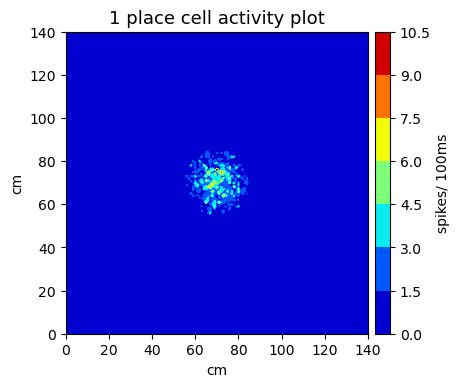

0.5430457592010498


In [219]:
def plotTestCell(testCell= testCell, height= height, width= width):
    '''
    Visualizes the activity of one object of class PlaceCell inside the 2D experimental environment as a heat map.

    Arguments:
    height & weight - dimensions of experiemntal environment in cm
    testCell - object of class PlaceCell

    Returns:
    None - Prints heat map of test cell activity layout.
    '''
    x_coordinates = np.arange(start= 0, stop= width +1, step= 1)          # this actually adds 1 cm to the dimensions
    y_coordinates = np.arange(start= 0, stop= height +1, step= 1)         # this actually adds 1 cm to the dimensions. The room is really 141cm * 141cm
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            element = np.array([[x_coordinates[x]],         #width
                                [y_coordinates[y]]])        #height
            result = testCell.activity(element)
            Z[y][x] = result                                # this indexing solution is not very good. It makes the function run slowly. A broadcasting solution is preferred

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')     # vmin=0, vmax=20
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title("1 place cell activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    
    return
    
start = time.time()
plotTestCell()
end = time.time()
print(end - start)

# takes too much time. This function needs broadcasting solution.

### Place Cells list
Function that generates n_cells(int) place cells with randomly selected location of peak firing activity

In [220]:
def generatePlaceCells(n_cells= n_cells, sigma= sigma, height= height, width= width):
    '''
    Generates list of n_cells(int) objects of class PlaceCell where each object has randomly selected 
    location of peak firing activity within the simulated environment of dimensions height * width.

    Arguments:
    n_cells - number of place cell objects to initialize
    sigma - covariance matrix of place cell objects
    height & width - dimensions of experiemntal environment in cm

    Returns:
    List of n_cells place cell objects
    '''
    cellsList = []
    for i in range(n_cells):
        # here, mu is randomly selected location of peak firing activity of a given neuron
        mu = np.array([[random.uniform(0,width)],
                       [random.uniform(0,height)]])
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [221]:
# Generates a list of place cell objects used for subsequent neural activity data generation
cellsList = generatePlaceCells(n_cells, sigma, height, width)

## Plotting the current place fields

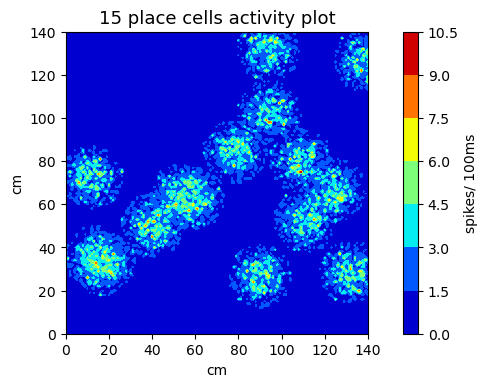

3.8485000133514404 seconds to print


In [222]:
def plotCells(cellsList= cellsList, height= height, width= width):
    '''
    Visualizes the superimposed activity of list of objects of class PlaceCell inside the 2D experimental environment as a heat map.

    Arguments:
    cellsList - list of objects of class PlaceCell
    height & weight - dimensions of experiemntal environment in cm

    Returns:
    None - Prints heat map of superimposed activity layout of all objects of class PlaceCell inside the function parameter cellsList
    '''
    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            location = np.array([[x_coordinates[x]],        #width
                                 [y_coordinates[y]]])       #height
            
            for placeCell in cellsList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.05)
    plt.title(str(len(cellsList)) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    return

start = time.time()
plotCells()
end = time.time()
print(end - start, "seconds to print")

## Colormapping

Here are two functions used for colormapping. Colormapping assigns a unique color to each coordinate in the experimental environment. This is then used to compare the colormap of the experimental environment with the latent manifolds produced by the diensionality reduction/manifold discovery methods.

In [223]:
def colormapLocation(coordinates, height= height, width= width):
    '''
    This function tailors color values for the coordinates inside the width * height environment.

    Arguments:
    coordinates - 2*n numpy array of the coordinates to be color coded
    height & weight - integer dimensions of experiemntal environment in cm

    Returns:
    colorValues - n*4 numpy array where each row carries color value for the input coordinates
    '''
    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX, normY = normalizeX(coordinates[0,:]), normalizeY(coordinates[1,:])

    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)
    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

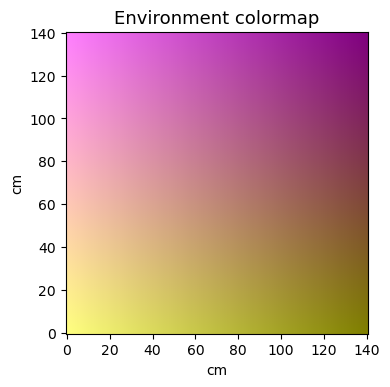

In [224]:
def plotColormapEnvironment(height= height, width= width, colorMap_function= colormapLocation):
    '''
    Prints color map of the original experimental environment where each coordinate has unique color value.
    The printed figure serves for direct comparison with latent latent manifold plots.

    Arguments:
    height & weight - integer dimensions of experiemntal environment in cm

    Returns:
    None - Prints color map of the original experimental environment
    '''
    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            dataLocation.append(location)

    colormap = colorMap_function(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    # Run the code without the ticks. Then, it chooses strange numbers for x-axis.
    # There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.show()
    return

plotColormapEnvironment()

# Generating data
The following code generates data, i.e., neural activity and corresponding location of the animal.

### All-knowing mouse function (MasterMouse)

In [225]:
def masterMouse(cellsList, height= height, width= width):       # nSteps= None
    '''
    Animal that systematically traverses through the environemnt. Discovers all of the locations.
    Generates neural data and corresponding location data of the environment.

    Arguments:
    cellsList - list of objects of class PlaceCell
    height & weight - dimensions of experiemntal environment in cm

    Returns:
    data - ((height * width) * len(cellsList)) numpy array denoting activty of the objects of class PlaceCell
    dataLocation - (2 * (height * width)) numpy array. [0, j] - width, [1, j] - height
    '''
    # nSteps not used
    x_coordinates = np.arange(start= 0, stop= width +1, step= 1)
    y_coordinates = np.arange(start= 0, stop= height +1, step= 1)

    data = []
    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            # dataLocation.append(location)
            dataLocation.append(np.copy(location))

            sample = []
            for placeCell in cellsList:
                sample.append(placeCell.activity(location))
            # data.append(np.hstack(sample))
            data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
    # dataLocation = np.vstack(dataLocation)

    return (data, dataLocation)

Generating masterMouse data and checking array shapes

In [226]:
(masterMouseData, masterMouseLocation) = masterMouse(cellsList)

print("masterMouseData shape is " + str(masterMouseData.shape))
print("masterMouseLocation shape is " + str(masterMouseLocation.shape))

masterMouseData shape is (19881, 15)
masterMouseLocation shape is (2, 19881)


### Randomly teleporting mouse function (RandomMouse)

In [227]:
def randomMouse(cellsList, nSteps, height= height, width= width):
    '''
    Animal that randomly explores  the environemnt. The movement is non-dynamic. The animal's location does not depend on its previous coordinates.
    The environment coordinates are generated randomly.
    Generates neural data and corresponding location data of the environment.

    Arguments:
    cellsList - list of objects of class PlaceCell
    nSteps - integer. number of environment coordinates and neural activity sample points to generate
    height & weight - both integers. dimensions of experiemntal environment in cm

    Returns:
    data - (nSteps * len(cellsList)) numpy array denoting activty of the objects of class PlaceCell
    dataLocation - (2 * nSteps) numpy array denoting animal's location corresponding to the neural activity data. [0, j] - width, [1, j] - height
    '''
    data = []
    dataLocation = []
    for i in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        # dataLocation.append(location)
        dataLocation.append(np.copy(location))

        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))
        
    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
        
    return (data, dataLocation)

Generating masterMouse data and checking array shapes

In [228]:
(randomMouseData, randomMouseLocation) = randomMouse(cellsList = cellsList, nSteps = 10000)

print("randomMouseData shape is " + str(randomMouseData.shape))
print("randomMouseLocation is " + str(randomMouseLocation.shape))

randomMouseData shape is (10000, 15)
randomMouseLocation is (2, 10000)


### Generate spikes based on locations (helper function)
However, the function is not used for any data generation.

In [229]:
def generateSpikes(cellsList, coordinates):
    '''
    Generates spikes based on input x and y coordinates

    Arguments:
    cellsList - list of objects of class PlaceCell
    nSteps - integer. number of environment coordinates and neural activity sample points to generate
    height & weight - both integers. dimensions of experiemntal environment in cm

    Returns:
    data - (coordinates.shape[1] * len(cellsList)) numpy array denoting activty of the objects of class PlaceCell per coordinate (coordinates column vectors)
    '''
    coordinates = np.hsplit(coordinates,len(coordinates[0,:]))
    data = []
    for location in coordinates:
        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    
    return(data)

Generating drunkMouse data and checking array shapes

# MasterMouse data exploration
Explore data generated by the masterMouse function.

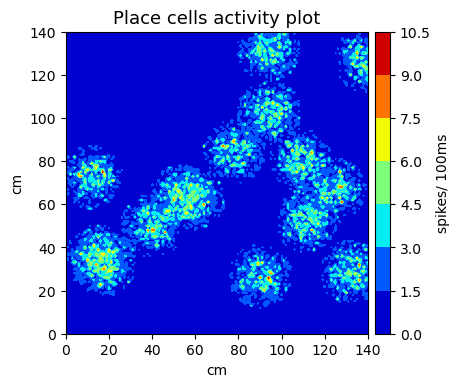

In [230]:
def plotOrderedData(data, title= "title", units= "units", colorbarLabel= "colorbarLabel", height= height, width= width):
    '''
    This function takes neural activity data generated by masterMouse function and plots across the room. The function superimposes the activity as a heat map.
    The plot is very similar to plotCells function. The poisson random noise is, however, different.

    Arguments:
    data - (n * m) numpy array where n is number of sample points and m is number of neurons. The array is neural activity data generated by masterMouse function
    title - string
    units - string
    colorbarLabel - string
    height & weight - both integers. dimensions of experiemntal environment in cm

    Returns:
    None. Prints heat map of superimposed activity layout data contained in argument data.
    '''
    x_coordinates = np.arange(start = 0, stop = width +1, step = 1)
    y_coordinates = np.arange(start = 0, stop = height +1, step = 1)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = data[:, 0]

    for index in range(data.shape[1]):
        Z = np.maximum(Z, data[:, index])

    Z = Z.reshape(len(x_coordinates),len(y_coordinates))

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = colorbarLabel, pad = -0.17)
    plt.title(title, size = 13)
    plt.xlabel(units)
    plt.ylabel(units)
    plt.axis('square')
    plt.show()
    return

plotOrderedData(masterMouseData, title= "Place cells activity plot", units= "cm", colorbarLabel= "spikes/ 100ms")

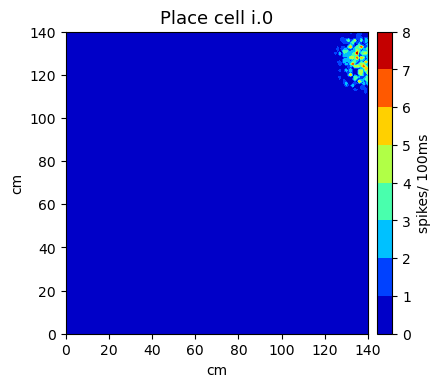

In [231]:
def plotDataCell(data, index= 0, title= "title", units= "units", colorbarLabel= "colorbarLabel", height= height, width= width,):
    '''
    Plots activity generated by one object of class PlaceCell. Select neuron by its index, i.e., column vector in neural activity numpy array generated by masterMouse function.
    Arguments:
        data - (n * m) numpy array where n is number of sample points and m is number of neurons. The array is neural activity data generated by masterMouse function
        ndex - index of column vector of argument data.
        title - string
        units - string
        colorbarLabel - string
        height & weight - both integers. dimensions of experiemntal environment in cm
    Returns:
        None. Prints heat map of activity of one object of class PlaceCell argument data.
    '''
    cell = data[:,index]

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')

    Z = cell.reshape(len(x_coordinates),len(y_coordinates))

    plt.figure(dpi=100)    # figsize=(width, height)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = colorbarLabel, pad = -0.16)
    plt.title(title, size = 13)
    plt.xlabel(units)
    plt.ylabel(units)
    plt.axis('square')
    plt.show()
    return

# pick index of a neuron to be visualized by the subsequent function call
index = 0
plotDataCell(data= masterMouseData, index= index, title= ("Place cell i." + str(index)), units = "cm", colorbarLabel= "spikes/ 100ms")

## Master Mouse PCA
Pincipal Component Analysis of neural data generated by the masterMouse function

In [232]:
# prepare data contained in masterMouseData variable generated above

masterZscore = zscore(masterMouseData)                                          # calculate z-score of each value along axis 0
masterZscore = np.nan_to_num(masterZscore)                                      # replace NaN with zero and infinity with a large finite number

# run PCA
masterMousePCA = PCA()                                                          # create object of class PCA
masterMousePCA.fit(masterZscore)                                                # fit the model with masterZscore

masterWeights = masterMousePCA.components_                                      # eigenvectors ordered by eigenvalues
masterVariance = masterMousePCA.explained_variance_                             # eigenvalues - amount of variance explained by each of the selected components 
masterExplainedVariance = np.cumsum(masterVariance)/np.sum(masterVariance)      # 1D array cumulative sum of eigenvalues divided by sum of the eigenvalues
masterPCA_scores = masterMousePCA.transform(masterZscore)                       # apply dimensionality reduction to masterZscore. Returns latent variables

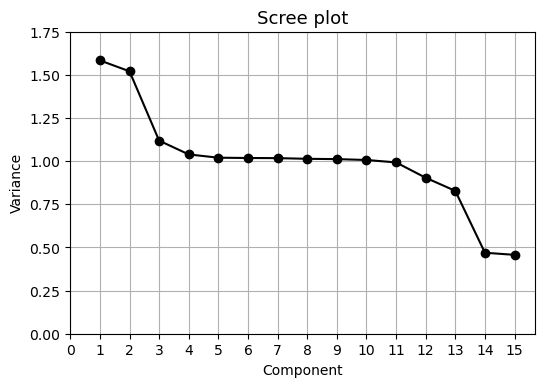

In [233]:
def plotVariance(variance):
    '''
    Plots variance (eigenvalues) in decreasing order
    Arguments:
        variance - numpy array. Vector of eigenvalues
    Returns:
        None. Prints scree plot of eigenvalues (varience)
    '''
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(variance) + 1), variance, 'o-k')

    # plt.loglog(np.arange(1, len(variance) + 1), variance, 'o-k')

    plt.title('Scree plot', size = 13)
    plt.xlabel('Component')
    plt.xticks(np.arange(0, len(variance)+1))                       ### is there a better way of doing this
    plt.ylabel('Variance')                                          # eigenvalues
    plt.yticks(np.arange(0, max(variance)+0.25, step=0.25))
    plt.grid()
    plt.show()
    return

plotVariance(masterMousePCA.explained_variance_)

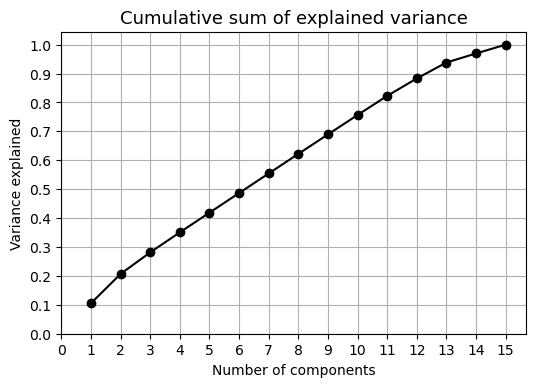

In [234]:
def plotVarianceExplained(explainedVariance):
    """
    Plots cumulative sum of variance
    Arguments:
        explainedVariance - numpy array. Vector of variance explained for each PC
    Returns:
        None. Plots cumulative sum of normalized variance (eigenvalues)
    """
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, 'o-k')

    plt.title('Cumulative sum of explained variance', size = 13)

    plt.xlabel('Number of components')
    plt.xticks(np.arange(0, len(explainedVariance)+1))
    plt.ylabel('Variance explained')
    plt.yticks(np.arange(0, max(explainedVariance)+0.05, step=0.1))

    plt.grid()
    plt.show()
    return

plotVarianceExplained(masterExplainedVariance)

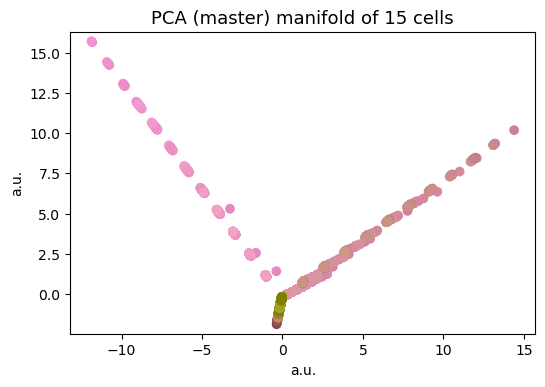

In [235]:
# plot two components

def plot_two_pca_components(scores, location, type_of_mouse= "unknown mouse"):
    '''
    Plots first two latent variables of input data in 2D scatter plot
    Arguments:
        scores - numpy array. scores of dimensionality reduction method
        location - 2*n numpy array. 2D coordinates corresponding to the scores argument
    Returns:
        None. Prints scatter plot
    '''
    plt.figure(dpi=100)
    plt.scatter(scores[:, 0], scores[:, 1], c= colormapLocation(location))

    plt.title(("PCA (" + type_of_mouse + ") manifold of " + str(n_cells) + " cells"), size= 13)
    plt.xlabel("a.u.")
    plt.ylabel("a.u.")      # arbitrary units
    plt.gca().set_aspect('equal', 'datalim')
    return

foo = plot_two_pca_components(masterPCA_scores, masterMouseLocation, "master")

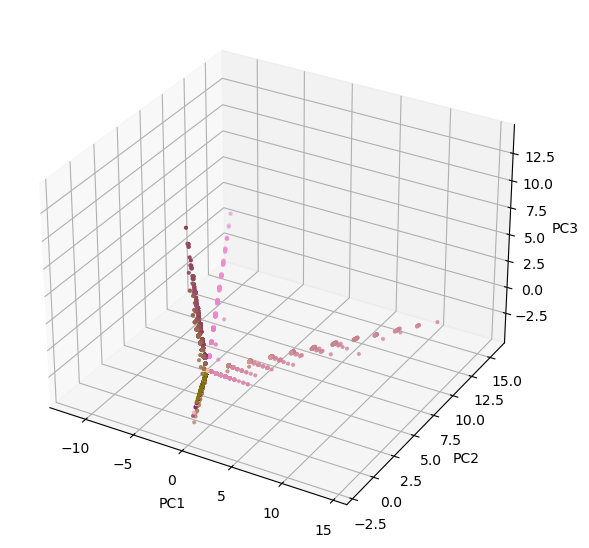

In [236]:
# plot three components

def plotThreeComponents(scores, location):
    '''
    Plots first three latent variables of input data in 3D scatter plot.
    Arguments:
        scores - numpy array. scores of dimensionality reduction method
        location - 2*n numpy array. 2D coordinates corresponding to the scores argument
    Returns:
        None. Prints scatter plot
    '''
    # %matplotlib notebook              # does not work in VS code
    lv_1, lv_2, lv_3 = scores[:,0], scores[:,1], scores[:,2]
    colorMap = colormapLocation(location)

    plt.figure(dpi=100, figsize=(7,7))
    plt.clf()
    # plt.title('First three principal components scatter plot')

    ax = plt.axes(projection='3d')
    # ax.scatter3D(lv_1, lv_2, lv_3, s = 4)
    ax.scatter3D(lv_1, lv_2, lv_3, c= colorMap, s = 4)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # ax.view_init(30,30)

    plt.show()
    return

plotThreeComponents(masterPCA_scores,masterMouseLocation)

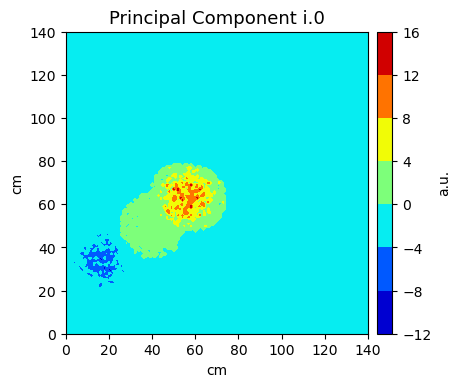

In [237]:
# Use plotDataCell function to plot principal component of masterMouse. plotDataCell was originally writen to print neural activity of masterMouse.
# However, it can be also used to print environmental layout of PCs derived from masterMouse.
index = 0

plotDataCell(data = masterPCA_scores, index = index, title = ("Principal Component i." + str(index)), units = "cm", colorbarLabel = "a.u.")

### Data reconstruction
Reconstructiong original data from masterMouse using PCs

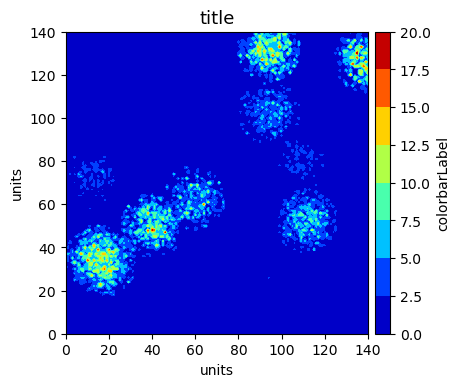

In [238]:
# Master Scores by hand
masterScoresByHand = masterZscore @ masterWeights               # calculating masterMouse scores 'by hand'
K = n_cells//2                                                  # number of PC's to use to reconstruct the original data (actually, z-score)

masterScoresByHandCut = masterScoresByHand[:, :K]
masterWeightsCut = masterWeights[:, :K]
masterDataRecon = masterScoresByHandCut @ masterWeightsCut.T    # this gives me back approximation of masterZscore

# plotDataCell(masterDataRecon, 0)

plotOrderedData(masterDataRecon)

# Random Mouse Data Exploration

## Random mouse PCA

In [239]:
# prepare data contained in randomMouseData variable generated above

randomZscore = zscore(randomMouseData)                                          # calculate z-score of each value along axis 0
randomZscore = np.nan_to_num(randomZscore)                                      # replace NaN with zero and infinity with a large finite number

# run PCA
randomMousePCA = PCA()                                                          # create object of class PCA
randomMousePCA.fit(randomZscore)                                                # fit the model with randomZscore

randomWeights = randomMousePCA.components_                                      # eigenvectors ordered by eigenvalues
randomVariance = randomMousePCA.explained_variance_                             # eigenvalues - amount of variance explained by each of the selected components
randomExplainedVariance = np.cumsum(randomVariance)/np.sum(randomVariance)      # 1D array cumulative sum of eigenvalues divided by sum of the eigenvalues
randomPCA_scores = randomMousePCA.transform(randomZscore)                       # apply dimensionality reduction to randomZscore. Returns latent variables

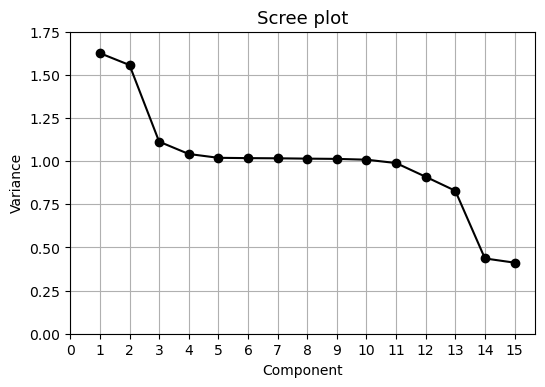

In [240]:
plotVariance(randomMousePCA.explained_variance_)

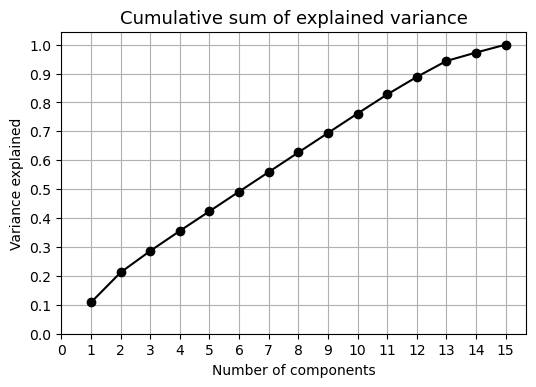

In [241]:
randomExplainedVariance = np.cumsum(randomMousePCA.explained_variance_)/np.sum(randomMousePCA.explained_variance_)
plotVarianceExplained(randomExplainedVariance)

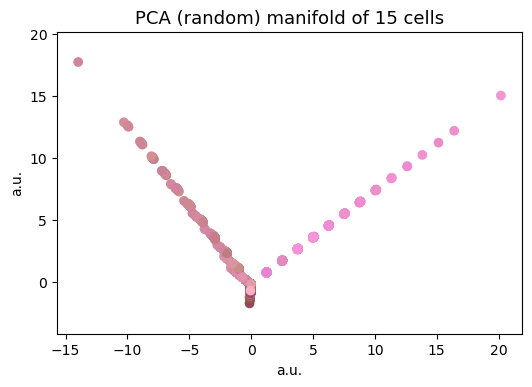

In [242]:
plot_two_pca_components(randomPCA_scores, randomMouseLocation, "random")

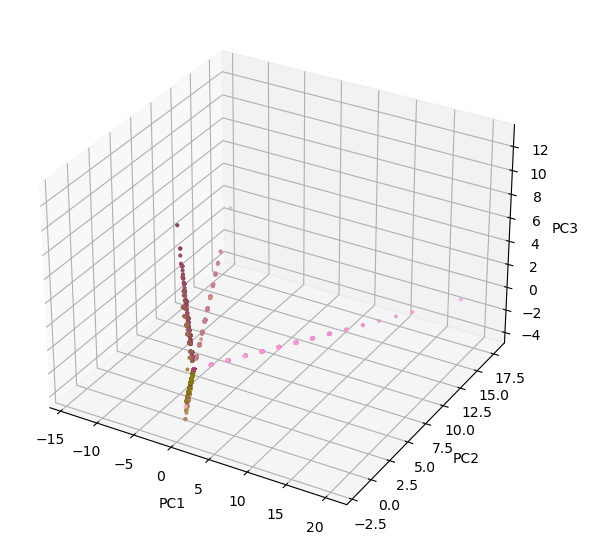

In [243]:
## plot three components

plotThreeComponents(randomPCA_scores, randomMouseLocation)

### Data reconstruction

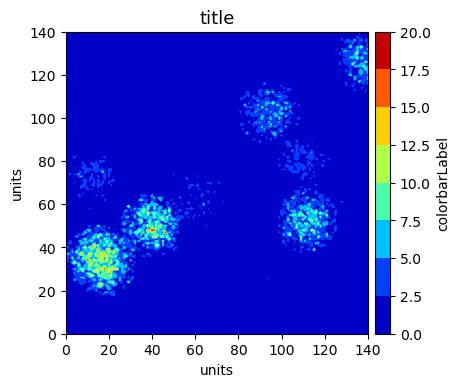

In [244]:
# master scores are applied to random weights to reconstruct the original data

# Master Scores by hand
masterScoresByHand = masterZscore @ masterWeights               # calculating masterMouse scores 'by hand'
K = n_cells//2                                                  # number of PC's to use to reconstruct the original data (actually, z-score)

masterScoresByHandCut = masterScoresByHand[:, :K]
randomWeightsCut = randomWeights[:, :K]
randomDataRecon = masterScoresByHandCut @ randomWeightsCut.T    # this should give me back approximation of randomZscore

# plotDataCell(randomDataRecon, 0)
plotOrderedData(randomDataRecon)

# Uniform Manifold Approximation and Projection (UMAP)

## Master mouse UMAP

In [245]:
# run UMAP

masterReducer = umap.UMAP()
masterUMAP_embedding = masterReducer.fit_transform(masterZscore)

print(masterUMAP_embedding.shape)

(19881, 2)


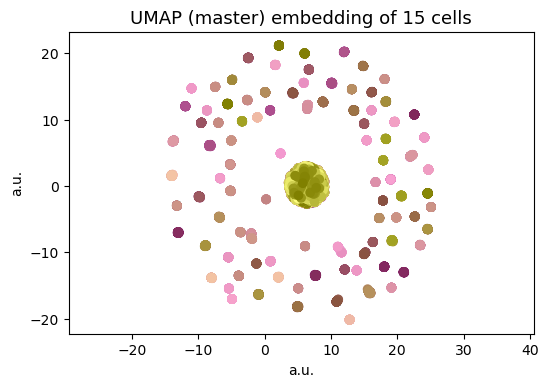

In [246]:
# plot data

plt.figure(dpi=100)
plt.scatter(masterUMAP_embedding[:, 0], masterUMAP_embedding[:, 1], c= colormapLocation(masterMouseLocation))

plt.title(("UMAP (master) embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

## Random mouse UMAP

In [247]:
# run UMAP

randomReducer = umap.UMAP()
randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

print(randomUMAP_embedding.shape)

(10000, 2)


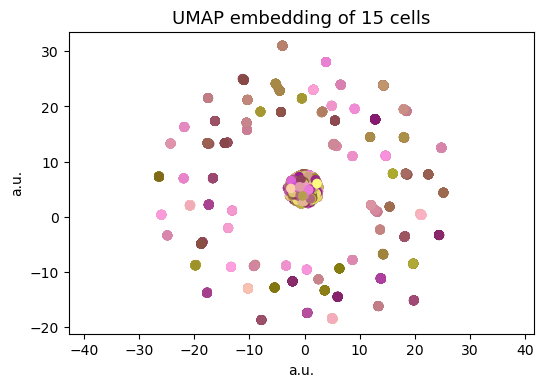

In [248]:
# plot data

plt.figure(dpi=100)
plt.scatter(randomUMAP_embedding[:, 0], randomUMAP_embedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("UMAP embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

# Laplacian Eigenmaps (Spectral Embedding or LEM)

## Master mouse LEM

In [249]:
# # LEM is generally very slow. I usually keep the code commented out
# # run LEM

# masterLaplacian = SpectralEmbedding(n_components = 2)
# masterLaplacianEmbedding = masterLaplacian.fit_transform(masterZscore)

# print(masterLaplacianEmbedding.shape)

In [250]:
# plt.figure(dpi=100)
# plt.scatter(masterLaplacianEmbedding[:, 0], masterLaplacianEmbedding[:, 1], c= colormapLocation(masterMouseLocation))

# plt.title(("Laplacian (master) embedding of " + str(n_cells) + " cells"), size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

### Save/load data

In [251]:
# masterLaplacianEmbedding = np.load("masterLaplacianEmbedding_run1.npy")
# masterMouseLocation = np.load("masterMouseLocation_run1.npy")

In [252]:
# np.save("masterLaplacianEmbedding_run1.npy", masterLaplacianEmbedding)
# np.save("masterMouseDataLocation_run1.npy", masterMouseLocation)

## Random mouse LEM

In [253]:
# # LEM is generally very slow. I usually keep the code commented out
# # run LEM

# randomLaplacian = SpectralEmbedding(n_components = 2)
# randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)

# print(randomLaplacianEmbedding.shape)

In [254]:
# plt.figure(dpi=100)
# plt.scatter(randomLaplacianEmbedding[:, 0], randomLaplacianEmbedding[:, 1], c= colormapLocation(randomMouseLocation))

# plt.title(("Laplacian embedding of " + str(n_cells) + " cells"), size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

### Save/load data

In [255]:
# randomLaplacianEmbedding = np.load("randomLaplacianEmbedding_run1.npy")
# randomMouseLocation = np.load("randomMouseDataLocation_run1.npy")

In [256]:
# np.save("randomLaplacianEmbedding_run1.npy", randomLaplacianEmbedding)
# np.save("randomMouseLocation_run1.npy", randomMouseLocation)

# Comparing distances
This code compares distances within the experimental environment and its corresponding coordinates. It then calculates the Pearson correlation coefficient of the real coordinates and its projections. This is done for each dim. reduction method individually.

In [257]:
# preapare data

masterPCA_scores_transpose = masterPCA_scores.T[:2,:]
masterUMAP_embedding_transpose = masterUMAP_embedding.T
# masterLaplacianEmbedding_transpose = masterLaplacianEmbedding.T

randomPCA_scores_transpose = randomPCA_scores.T[:2,:]
randomUMAP_embedding_transpose = randomUMAP_embedding.T
# randomLaplacianEmbedding_transpose = randomLaplacianEmbedding.T

In [258]:
print("masterMouseLocation shape is", masterMouseLocation.shape)
print("masterPCA_scores_transpose shape is", masterPCA_scores_transpose.shape)
print("masterUMAP_embedding_transpose shape is", masterUMAP_embedding_transpose.shape)
# print("masterLaplacianEmbedding_transpose shape is", masterLaplacianEmbedding_transpose.shape)
print()

print("randomMouseLocation shape is", randomMouseLocation.shape)
print("randomPCA_scores_transpose shape is", randomPCA_scores_transpose.shape)
print("randomUMAP_embedding_transpose shape is", randomUMAP_embedding_transpose.shape)
# print("randomLaplacianEmbedding_transpose shape is", randomLaplacianEmbedding_transpose.shape)

masterMouseLocation shape is (2, 19881)
masterPCA_scores_transpose shape is (2, 19881)
masterUMAP_embedding_transpose shape is (2, 19881)

randomMouseLocation shape is (2, 10000)
randomPCA_scores_transpose shape is (2, 10000)
randomUMAP_embedding_transpose shape is (2, 10000)


In [259]:
def pickRandomLocations(locations, number_of_samples= 100):
    '''
    pick random numbers corresponding to indicies of coordinates,
    neural activity sample points, or their projections in manifolds
    Arguments:
        locations - 2*n numpy array denoting recorded locations of the animal
        number_of_samples - integer. number of desired sample points. The number cannot be bigger than n of argument locations
    Returns:
        samples - List containing integers
    '''
    locationsLength = locations.shape[1]
    samples = random.sample(range(locationsLength), number_of_samples)

    # The number of samples is limited by the number of recorded cordinates.
    # However, the actual number of coordinate pairs is factorial of the cordinates. The code could be changed to reflect this.
    return samples

# coordinate_indicies = pickRandomLocations(masterMouseLocation, 10000)
coordinate_indicies = pickRandomLocations(randomMouseLocation, 10000)

print(len(coordinate_indicies))

10000


In [260]:
def distanceMeasure(coordinates, coordinate_indicies):
    '''
    Calculates Euclidian distance between coordinates in 2D environment.
    Arguments:
        coordinates - 2*n numpy array
        coordinate_indicies - list of integers
    Returns:
        distances[1:] - list of integers. Distances between successive coordinates set by coordinate_indicies
    '''
    locations = []
    for i in coordinate_indicies:
        locations.append(coordinates[:, i])

    locations_copy = locations.copy()
    used_locations = []
    distances = []

    for i in range(len(locations)):
        current_coordinate = locations_copy.pop(0)
        try:
            distance = np.linalg.norm(current_coordinate - used_locations[-1])
        except IndexError:
            distance = 0

        distances.append(distance)
        used_locations.append(current_coordinate)

    return distances[1:]                  # the first value is always zero. This would skew Pearson's r a bit. Therefore, it is omitted.

In [261]:
master_real_distance = distanceMeasure(masterMouseLocation, coordinate_indicies)
master_umap_distance = distanceMeasure(masterUMAP_embedding_transpose, coordinate_indicies)
master_pca_distance = distanceMeasure(masterPCA_scores_transpose, coordinate_indicies)
# master_laplacian_distance = distanceMeasure(masterLaplacianEmbedding_transpose, coordinate_indicies)


Text(0, 0.5, 'units')

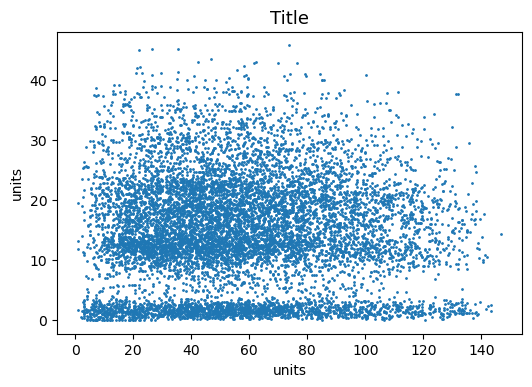

In [59]:
plt.figure(dpi=100)

plt.scatter(master_real_distance, master_umap_distance, s= 1)

plt.title(("Title"), size= 13)
plt.xlabel("units")
plt.ylabel("units")


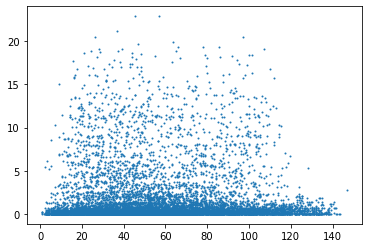

In [60]:
plt.scatter(master_real_distance, master_pca_distance, s= 1)

In [61]:
# plt.scatter(master_real_distance, master_laplacian_distance, s= 1)

In [62]:
print(pearsonr(master_real_distance, master_umap_distance))
print(pearsonr(master_real_distance, master_pca_distance))
# print(pearsonr(master_real_distance, master_laplacian_distance))

PearsonRResult(statistic=-0.020002830938620597, pvalue=0.04548589234462423)
PearsonRResult(statistic=-0.012888439379928363, pvalue=0.1975121788437028)


In [63]:
random_real_distance = distanceMeasure(randomMouseLocation, coordinate_indicies)
random_umap_distance = distanceMeasure(randomUMAP_embedding_transpose, coordinate_indicies)
random_pca_distance = distanceMeasure(randomPCA_scores_transpose, coordinate_indicies)
# random_laplacian_distance = distanceMeasure(randomLaplacianEmbedding_transpose, coordinate_indicies)

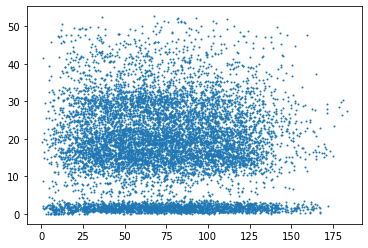

In [64]:
plt.scatter(random_real_distance, random_umap_distance, s= 1)

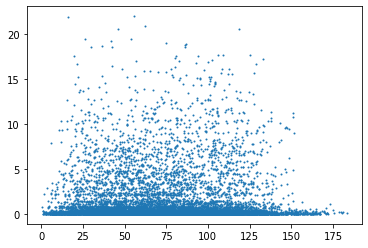

In [65]:
plt.scatter(random_real_distance, random_pca_distance, s= 1)

In [66]:
# plt.scatter(random_real_distance, random_laplacian_distance, s= 1)

In [67]:
print(pearsonr(random_real_distance, random_umap_distance))
print(pearsonr(random_real_distance, random_pca_distance))
# print(pearsonr(random_real_distance, random_laplacian_distance))

PearsonRResult(statistic=-0.040388608427155775, pvalue=5.349628666669529e-05)
PearsonRResult(statistic=0.0004408214111107149, pvalue=0.9648450762660539)


# Notes, tests, dev. code, etc.

In [68]:
# # dev version of realDistanceMeasure

# coordinates = np.array([[5,2,10,5,1],
#                         [3,2,0,9,1]])

# def realDistanceMeasure(coordinates, coordinate_indicies):

#     locations = []
#     # for i in coordinate_indicies:
#     for i in range(5):
#         locations.append(coordinates[: , i])

#     locations_copy = locations.copy()
#     used_locations = []
#     cumulative_distance = []

#     for i in range(len(locations)):
#         print("i EQUALS", i)
#         current_coordinate = locations_copy.pop(0)
#         print("CURRENT COORDINATE IS", current_coordinate)
#         print("used_locations are", used_locations)

#         try:
#             distance = np.linalg.norm(current_coordinate - used_locations[-1])
#         except IndexError:
#             distance = 0

#         print("distance is", distance)
        
#         cumulative_distance.append(distance)
#         print("cummulative distance is", cumulative_distance)
#         used_locations.append(current_coordinate)

#     print("final used locationd are", used_locations )
#     return cumulative_distance

# # foo = realDistanceMeasure(masterMouseLocation, coordinate_indicies)
# foo = realDistanceMeasure(coordinates, coordinate_indicies)
# print(foo)

In [69]:
# # dev version of realDistanceMeasure

# coordinates = np.array([[5,2,10,5,1],
#                         [3,2,0,9,1]])

# def realDistanceMeasure(coordinates, coordinate_indicies):

#     locations = []
#     # for i in coordinate_indicies:
#     for i in range(5):
#         locations.append(coordinates[: , i])

#     locations_copy = locations.copy()
#     used_locations = []
#     cumulative_distance = []

#     for i in range(len(locations)):
#         print("i EQUALS", i)
#         current_coordinate = locations_copy.pop(0)
#         print("CURRENT COORDINATE IS", current_coordinate)
#         print("used_locations are", used_locations)
#         distance = 0
#         for loc in used_locations:
#             print("current loc is", loc)
#             distance += np.linalg.norm(current_coordinate - loc)
#             print("currebnt norm is", np.linalg.norm(current_coordinate - loc))
#             print("distance is", distance)
        
#         # try:
#         #     distance += cumulative_distance[-1]
#         # except IndexError:
#         #     distance += 0
        
#         cumulative_distance.append(distance)
#         print("cummulative distance is", cumulative_distance)
#         used_locations.append(current_coordinate)

#     print("final used locationd are", used_locations )
#     return cumulative_distance

# # foo = realDistanceMeasure(masterMouseLocation, coordinate_indicies)
# foo = realDistanceMeasure(coordinates, coordinate_indicies)
# print(foo)

## Generating trials

In [70]:
# ## adding master trials into 3D array

# def collectTrials(dataGenerator, numTrials, nSteps= 1):

#     dataList = []
#     locationList = []
#     for i in range(numTrials):
#         (data, location) = dataGenerator(cellsList, nSteps, height, width)

#         dataList.append(data)
#         locationList.append(location)

#     trialsData = np.stack(dataList)
#     trialsLocation = np.stack(locationList)

#     return trialsData, trialsLocation


In [71]:
# # trials master mouse
# trialsData, trialsLocation = collectTrials(masterMouse, 10)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [72]:
# # trials random mouse
# trialsData, trialsLocation = collectTrials(randomMouse, 10, 20000)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [73]:
# # trials drunkard's walk mouse
# trialsData_train, trialsLocation_train = collectTrials(drunkMouse, 200, 10000)
# trialsData_val, trialsLocation_val = collectTrials(drunkMouse, 200, 10000)

# print(trialsData_train.shape)
# print(trialsLocation_train.shape)

In [74]:
# trialsData, trialsLocation = collectTrials(linearMouse, 1000, nSteps= 70)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [75]:
# linearMouseLocation = trialsLocation.reshape(2, 70000)          # look closely at what's happening here, the plot shuld not look like this
# plt.plot(linearMouseLocation[0,:], linearMouseLocation[1,:])

In [76]:
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testData_train",trialsData_train)
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testDataLocation_train",trialsLocation_train)

# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testData_val",trialsData_val)
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testDataLocation_val",trialsLocation_val)

## Dynamic movement
Implementation of dynamic movement of the anima. However, the function is not used for any data generation.

### Random walk

In [77]:
# def drunkMouse(cellsList, nSteps, height= height, width= width):
#     '''
#     Generates movement coordinates of an animal and their corresponding neural activity.
#     The animal starts in the middle of the environment and each step moves randomly 1cm up, down, left, or right.

#     Arguments:
#     cellsList - list of objects of class PlaceCell
#     nSteps - integer. number of environment coordinates and neural activity sample points to generate
#     height & weight - both integers. dimensions of experiemntal environment in cm

#     Returns:
#     data - (nSteps * len(cellsList)) numpy array denoting activty of the objects of class PlaceCell
#     dataLocation - (2 * nSteps) numpy array denoting animal's location corresponding to the neural activity data. [0, j] - width, [1, j] - height
#     '''
#     cm = 1
#     movements = (np.array([[cm],[0]]), np.array([[-cm],[0]]), np.array([[0],[cm]]), np.array([[0],[-cm]]))

#     dataLocation = []
#     location = np.array([[width /2],
#                          [height /2]])        # first location is the middle of the environment

#     for i in range(nSteps):
#         dataLocation.append(np.copy(location))      # append(location) was clearly mistake but how about append(location[:,:])
#         nextMove = random.choice(movements)
#         location += nextMove
        
#         while (location[0,0] < 0 or location[0,0] > width) or (location[1,0] < 0 or location[1,0] > height):
#             location -= nextMove
#             nextMove = random.choice(movements)
#             location += nextMove

#     dataLocation = np.hstack(dataLocation)
#     data = generateSpikes(cellsList, dataLocation)

#     return (data, dataLocation)


# drunkMouseData, drunkMouseLocation = drunkMouse(cellsList, 10000)
# print("drunkMouseData shape is " + str(drunkMouseData.shape))
# print("drunkMouseLocation is " + str(drunkMouseLocation.shape))

# plt.plot(drunkMouseLocation[0, :], drunkMouseLocation[1, :])

# Other dimensionality reduction methods (tested but never fully carried out)

## MasterMouse ICA

In [78]:
# masterICA = FastICA()
# masterICA.fit(masterZscore)
# masterICAdata = masterICA.transform(masterZscore)

# plotOrderedData(masterICAdata)

In [79]:
# index = 0
# plotDataCell(data= masterICAdata, index= index, title= ("Independent Component i." + str(index)), units= "cm", colorbarLabel= "a.u.")

## RandomMouse ICA

In [85]:
# randomICA = FastICA()
# randomICA.fit(randomZscore)
# randomICAdata = randomICA.transform(randomZscore)

# plotDataCell(randomICAdata, 0)
# plt.show()

# Factor analysis

In [86]:
# from sklearn.decomposition import FactorAnalysis

In [87]:
# factorA = FactorAnalysis(n_components= 2)
# randomFactorA_transform = factorA.fit_transform(randomZscore)

# plt.scatter(randomFactorA_transform[:, 0], randomFactorA_transform[:, 1], c= colormapLocation(randomMouseLocation))

# Isomap

In [88]:
# from sklearn.manifold import Isomap

In [89]:
# isomap = Isomap(n_neighbors= 5, n_components= 2)
# randomIsoManifold = isomap.fit_transform(randomZscore)

In [90]:
# plt.scatter(randomIsoManifold[:, 0], randomIsoManifold[:, 1], c= colormapLocation(randomMouseLocation))

# t-sne

In [91]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components= 2)
# randomTsneManifold = tsne.fit_transform(randomZscore)

In [92]:
# plt.scatter(randomTsneManifold[:, 0], randomTsneManifold[:, 1], c= colormapLocation(randomMouseLocation))